In [ ]:
#RNN pour prévision du prix de l'EURUSD pour les trois prochains mois :

#Note sur le code : Après premier lancement du code, le prédiction est trop lisse loin de la réalité ce qui nous fait douter sur la précision de la prévision, pour ce faire
#on modifie les elements suivants :
#- On augmente le nombre de couche, à plus de 50.
#- On augmente la base de données, on change la base journalière pour une base horaire 
#- Ajout d'une stratégie comme le croisement des MMs, des BBs, ou autre pour accompagner la prévision du cours et nous aider à entrer en positions
#- Ajout du code qui assure la précision de l'entrainement de la machine depuis TENSERFLOW
#- Possibilté d'augmenter le pourcentage du Dropout, de telle façon qu'un Dropout entre 20 et 50% est considéré bien pour le modèle
#- Après la validation du modèle LSTM, ou GRU, on y ajoute un capitale, une fraction d'investissement et des niveaux de prix de sortie

import numpy as np #utilisé pour les matrices et les "arrays" 
import pandas as pd #facilite la manipulation de la data
import matplotlib.pyplot as plt #generer les nuages de points sous forme de graphe
from sklearn.preprocessing import MinMaxScaler #utilisé si la distribution n'est pas gaussienne
from tensorflow.keras.models import Sequential #assurer la séquence des couches du réseau neuronne
from tensorflow.keras.layers import LSTM, Dense, Dropout #pour le modèle LSTM


In [4]:
#cette partie est responsable sur l'extraction des données du temps, période journaliere, et du prix de cloture de l'EURUSD
def load_data(file_path):
    df = pd.read_csv(file_path, date_format=True) #lecture des données CSV
    df = df[['Date', 'Close']] #choix des colonnes date et prix de cloture
    df['Date'] = pd.to_datetime(df['Date']) #conversion de la date en 'datetime'
    df.set_index('Date', inplace=True) #tradnformation to datetime for pandas
    return df

Epoch 1/25


C:\Users\strus\AppData\Local\Temp\ipykernel_29040\2932904674.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date']) #conversion de la date en 'datetime'
c:\Users\strus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1554
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0392
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0268
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0194
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0191
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0157
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0163
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0185
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0140
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0157
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0131
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0135
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0125
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0143
Epoch 15/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0108
Epoch 16/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/

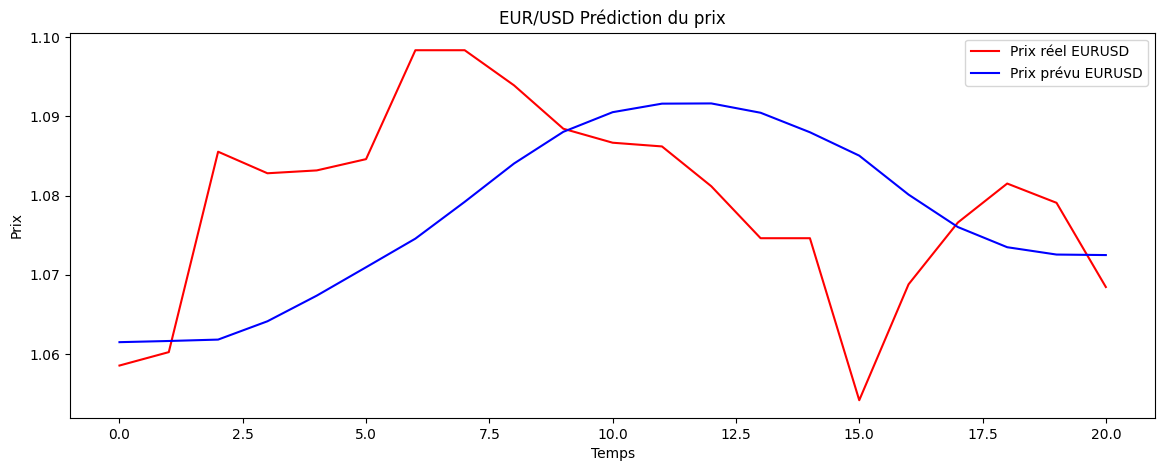

In [5]:
def prepare_data(df, window_size=60):
    data = df.values #conversion de la data en tableau
    scaler = MinMaxScaler(feature_range=(0,1)) #creation d'un minmaxscaler entre 0 et 1
    scaled_data = scaler.fit_transform(data) #normalisation des données (loi normale)

    x = [] #initialization de lla fonctionnalité
    y = [] #initialization de l'objectif
    for i in range(window_size, len(scaled_data)):
        x.append(scaled_data[i-window_size:i, 0]) #création de la fonction. basé sur la taille de la fenetre
        y.append(scaled_data[i, 0]) #création des objectifs basé sur la taille de la fenetre

    x, y = np.array(x), np.array(y) #conversion des listes en Numpy tableaux
    x = np.reshape(x, (x.shape[0], x.shape[1], 1)) #redimension du tableau en 3D
    return x, y, scaler

#Préparation et chargement des données :
file_path = 'C:/Users/strus/Downloads/eurusddata.csv' #chemin absolue du fichier 
df = load_data(file_path) #chargement du fichier
train_size = int(len(df) * 0.8) #80% des données seront utilisées pour l'entrainement
train_df = df[:train_size] #creation de la dataframe pour l'entrainement
test_df = df[train_size:] #creation de la dataframe pour le test

x_train, y_train, scaler = prepare_data(train_df) #préparation des données d'entrainement 
x_test, y_test, _ = prepare_data(test_df) #préparation des données de test

#Selection et entrainement du modèle LSTM :
model = Sequential() #activation du mode séquentiel 
model.add(LSTM(units=50, return_sequences= True, input_shape=(x_train.shape[1], 1))) #ajout de la couche à 50 unités
model.add(Dropout(0.2)) #20% d'abandon de couche pour l'optimisation du modèle
model.add(LSTM(units=50, return_sequences=False)) #ajout d'une seconde couche de 50 unités
model.add(Dropout(0.2)) #20% d'abandon de couche pour l'optimisation du modèle
model.add(Dense(units=1)) #couche d'output

model.compile(optimizer='adam', loss='mean_squared_error') #optimisation par ADAM qui consiste à maximiser l'utilisation des couches et du système
model.fit(x_train, y_train, epochs=25, batch_size=32) #epoch : est le nombre d'entrainement pendant la période d'apprentissage, dans ce cas est de 25. Batch : organisation des données

#Evaluation du modèle :
predicted_prices = model.predict(x_test) #prédiction via les donées du test
predicted_prices = scaler.inverse_transform(predicted_prices) #possesion du cours actuel
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1)) #check du prix actuel

plt.figure(figsize=(14, 5)) #figure pour plotting
plt.plot(real_prices, color='red', label='Prix réel EURUSD') #plotting du prix réel
plt.plot(predicted_prices, color='blue', label='Prix prévu EURUSD') #plotting du prix estimé
plt.title('EUR/USD Prédiction du prix')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.legend()
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


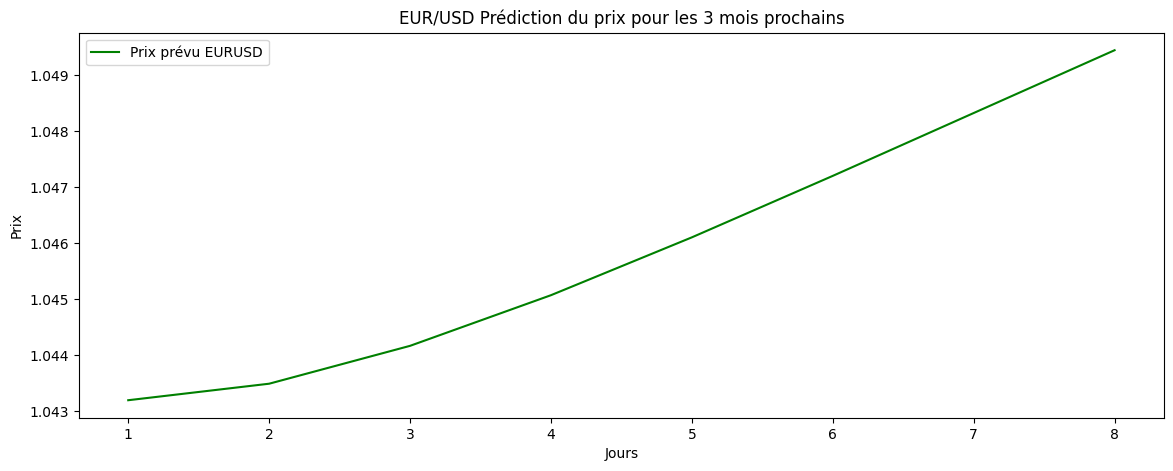

In [6]:
def predict_future_prices(model, last_window, n_days, scaler):
    future_predictions = [] #initialisation de la liste du cours futurs
    current_window = last_window #séquence des données

    for _ in range(n_days):
        prediction = model.predict(current_window) #prédiction de la prochaine valeur
        prediction = np.reshape(prediction, (1, 1, 1)) #array en 3D
        future_predictions.append(prediction[0, 0, 0]) #stockage de la prediction
        current_window = np.append(current_window[:, 1:, :], prediction, axis=1) #mis à jour de la fenetre

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)) #normaliser la derniere fenetre
    return future_predictions

last_window = df[-60:].values #prise de la derniere fentre
last_window = scaler.transform(last_window) #normalisation de la derniere fentre
last_window = np.reshape(last_window, (1, last_window.shape[0], 1)) #mise en 3D de la fenetre

future_prices = predict_future_prices(model, last_window, 8, scaler) #prévision du cours pour les 90 jours prochains

plt.figure(figsize=(14, 5)) #figure pour plotting
plt.plot(range(1, 9), future_prices, color='green', label='Prix prévu EURUSD') #plotting du prix prévu
plt.title('EUR/USD Prédiction du prix pour les 3 mois prochains')
plt.xlabel('Jours')
plt.ylabel('Prix')
plt.legend()
plt.show()
